In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from statsmodels.tsa.vector_ar.vecm import *

In [3]:
import statsmodels.datasets.interest_inflation.data as d
df = d.load_pandas().data
dates = df[["year", "quarter"]].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)
data = df[["Dp", "R"]]
data.index = pd.DatetimeIndex(quarterly)

In [4]:
# df.to_csv('time_data\\vecm_data.csv', index=False)

In [5]:
data
#Quarterly data: thus frequency (seasons) = 4

,Dp,R
1972-06-30,-0.003133,0.083
1972-09-30,0.018871,0.083
1972-12-31,0.024804,0.087
1973-03-31,0.016278,0.087
1973-06-30,0.000290,0.102
...,...,...
1997-12-31,0.024245,0.051
1998-03-31,-0.014647,0.047
1998-06-30,-0.002049,0.047
1998-09-30,0.002475,0.041


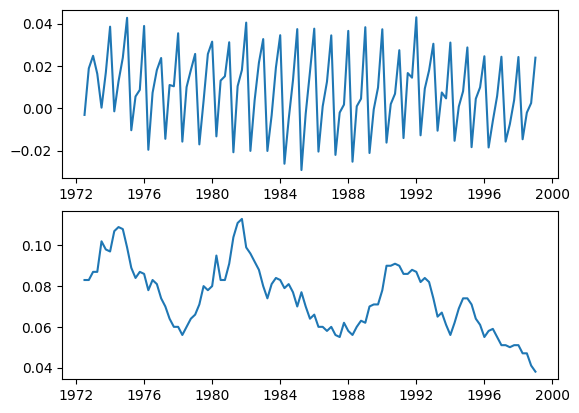

In [6]:
plt.figure()
ax = plt.subplot(211)
ax.plot(data.index, data["Dp"])
ax = plt.subplot(212)
ax.plot(data.index, data["R"])

In [7]:
# variable 'Dp' (inflation) has strong seasonal effect (thus include seasons=4)
# all observations of variable 'R' (interest) are greater than zero, so include an intercept (deterministic = 'ci')

# deterministic: str {“n”, “co”, “ci”, “lo”, “li”}
# "n" - no deterministic terms
# "co" - constant outside the cointegration relation
# "ci" - constant within the cointegration relation
# "lo" - linear trend outside the cointegration relation
# "li" - linear trend within the cointegration relation

lag order selection

In [8]:
lag_order = select_order(data=data, maxlags=10, deterministic='ci', seasons=4)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,-20.74,-20.37*,9.838e-10,-20.59*
1,-20.73,-20.25,9.984e-10,-20.53
2,-20.65,-20.06,1.079e-09,-20.41
3,-20.77*,-20.08,9.561e-10*,-20.49
4,-20.71,-19.91,1.020e-09,-20.38
5,-20.68,-19.77,1.054e-09,-20.31
6,-20.64,-19.63,1.094e-09,-20.23
7,-20.59,-19.47,1.162e-09,-20.13
8,-20.52,-19.29,1.247e-09,-20.02
9,-20.51,-19.17,1.271e-09,-19.97


In [9]:
# choose a lag order of 3 in the following cell if we are interested in the AIC

In [10]:
print(lag_order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 3, BIC -> 0, FPE -> 3, HQIC ->  0>


In [11]:
lag_order.aic

3

cointegration rank

In [12]:
rank_test = select_coint_rank(endog=data, det_order=0, k_ar_diff=3, method='trace', signif=0.05)
rank_test.rank

1

In [13]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,2,17.17,15.49
1,2,3.032,3.841


In [14]:
print(rank_test)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          17.17          15.49
  1   2          3.032          3.841
-------------------------------------


parameter estimation

In [15]:
model = VECM(data, deterministic='ci', seasons=4,
            k_ar_diff=lag_order.aic, # =3
            coint_rank= rank_test.rank) # =1

In [16]:
vecm_res = model.fit()

In [17]:
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
season1,0.0162,0.005,3.554,0.000,0.007,0.025
season2,0.0177,0.005,3.690,0.000,0.008,0.027
season3,0.0341,0.005,7.464,0.000,0.025,0.043
L1.Dp,-0.3339,0.141,-2.364,0.018,-0.611,-0.057
L1.R,0.0677,0.095,0.715,0.474,-0.118,0.253
L2.Dp,-0.3874,0.114,-3.399,0.001,-0.611,-0.164
L2.R,-0.0030,0.095,-0.032,0.975,-0.190,0.184
L3.Dp,-0.3457,0.076,-4.524,0.000,-0.495,-0.196
L3.R,0.0204,0.092,0.222,0.824,-0.160,0.201
,coef,std err,z,P>|z|,[0.025,0.975]


In [18]:
vecm_res.alpha

array([[-0.63174988],
       [ 0.39724572]])

In [19]:
vecm_res.stderr_alpha

array([[0.16663211],
       [0.17693968]])

In [20]:
# regarding alpha and beta: econometrics6 pg.54
# 외생적 충격이 발생했을 때 균형으로 회귀하는 속도를 나타내는 계수 (speed of adjustment)


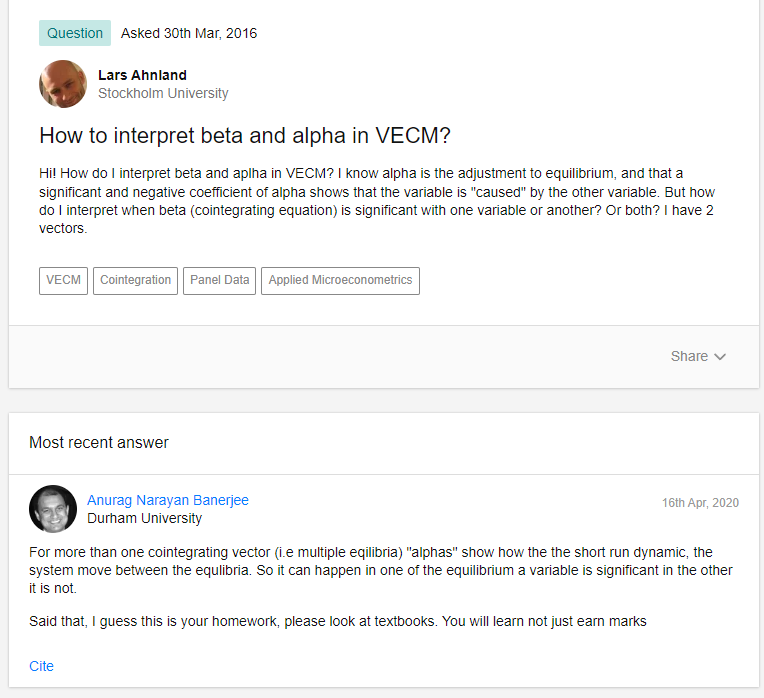

In [21]:
from IPython.display import Image
Image('images\\93.png')

forecasts

In [22]:
# Obtaining a forecast for the next  periods is as easy as calling the predict() method passing  as the steps argument. 
# To get confidence intervals, we also pass the desired confidence level to the argument alpha.

In [23]:
vecm_res.predict(steps=5)

array([[-0.02236238,  0.03961484],
       [-0.00390943,  0.04075971],
       [ 0.00331985,  0.04018359],
       [ 0.02437677,  0.03881549],
       [-0.02489008,  0.04001414]])

In [24]:
vecm_res.predict(steps=5, alpha=0.05)
for text, vaĺues in zip(("forecast", "lower", "upper"), vecm_res.predict(steps=5, alpha=0.05)):
    print(text+":", vaĺues, sep="\n")

forecast:
[[-0.02236238  0.03961484]
 [-0.00390943  0.04075971]
 [ 0.00331985  0.04018359]
 [ 0.02437677  0.03881549]
 [-0.02489008  0.04001414]]
lower:
[[-0.03177701  0.02961783]
 [-0.01359287  0.02532279]
 [-0.00657373  0.02100911]
 [ 0.01428314  0.01575236]
 [-0.03587008  0.01341332]]
upper:
[[-0.01294775  0.04961184]
 [ 0.005774    0.05619664]
 [ 0.01321343  0.05935806]
 [ 0.03447039  0.06187863]
 [-0.01391009  0.06661495]]


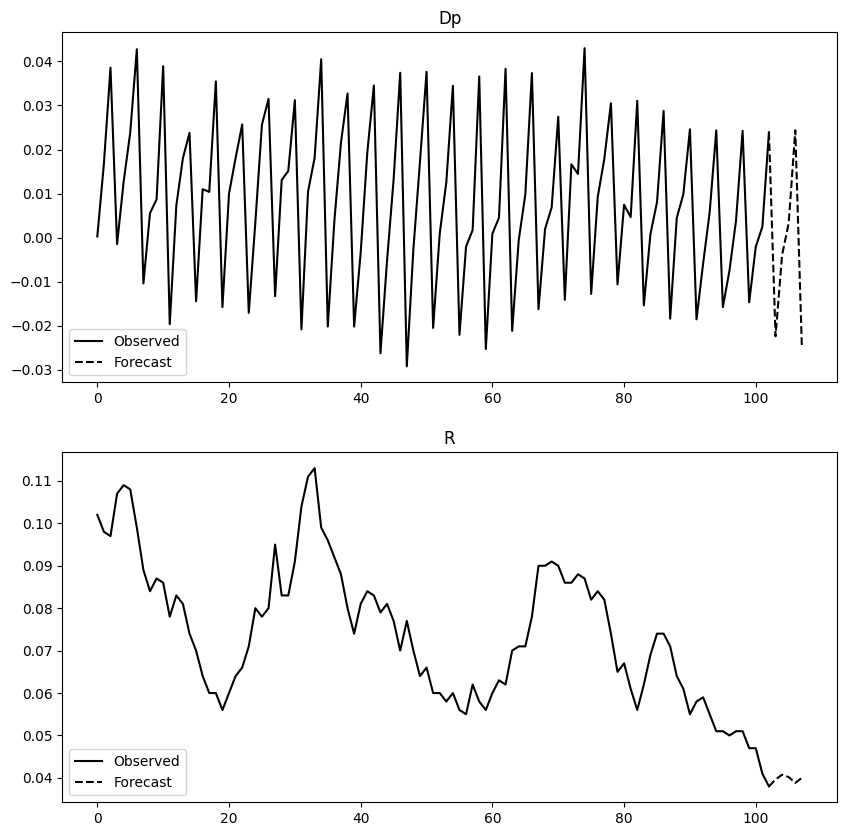

In [25]:
vecm_res.plot_forecast(steps=5, plot_conf_int=False)

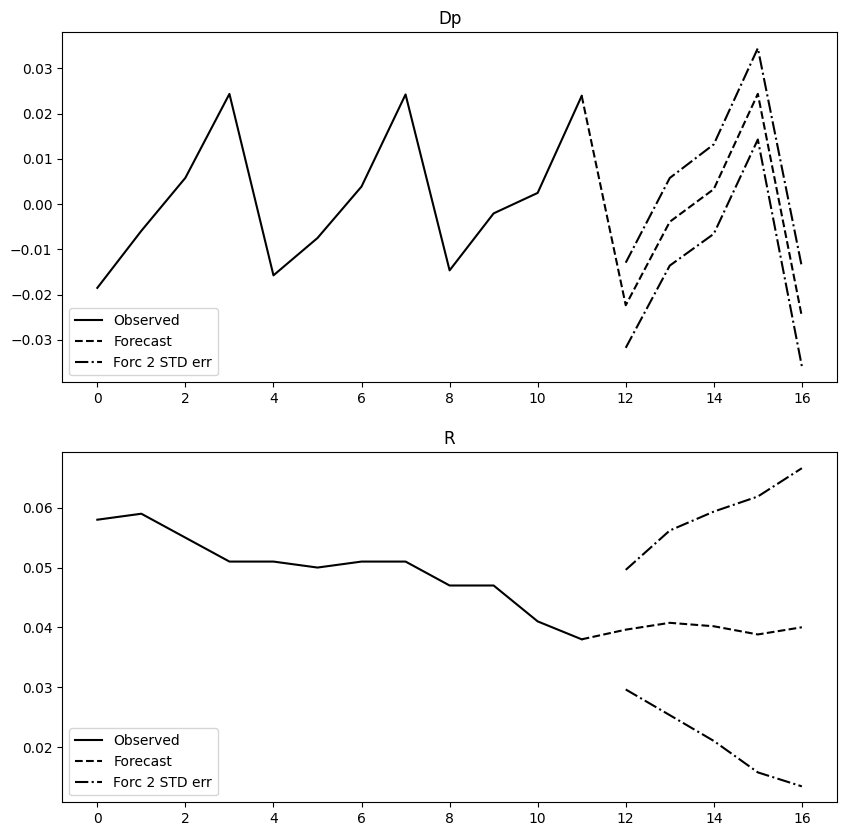

In [26]:
vecm_res.plot_forecast(steps=5, n_last_obs=12)

Structural analysis <br>
Granger Causality

In [27]:
granger_result = vecm_res.test_granger_causality(caused='Dp', signif=0.05)
granger_result.summary()

Test statistic,Critical value,p-value,df
3.531,2.423,0.008,"(4, 176)"


In [28]:
print(granger_result)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: R does not Granger-cause Dp: reject at 5% significance level. Test statistic: 3.531, critical value: 2.423>, p-value: 0.008>


Instantaneous causality

In [29]:
inst_caus_dp_r = vecm_res.test_inst_causality(causing="Dp")
inst_caus_r_dp = vecm_res.test_inst_causality(causing="R")
inst_caus_r_dp.summary()

Test statistic,Critical value,p-value,df
0.6068,3.841,0.436,1


We can also compare HypothesisTestResults objects (HypothesisTestResults is the base class of CausalityTestResults). Since instantaneous causality is a symmetric relation (this means that the roles of the caused and the causing variables may be swapped without effect), the following two tests are recognized as equal. Granger causality is not a symmetric relation, so swapping variables leads to CausalityTestResults instances which are not equal.

In [30]:
inst_caus_dp_r == inst_caus_r_dp

True

In [31]:
granger_result == vecm_res.test_granger_causality(caused="R", signif=0.05)

False

Impulse Response analysis

To analyze how an impulse in one variable affects the system, we can use the irf() method and call the returned object's plot method.

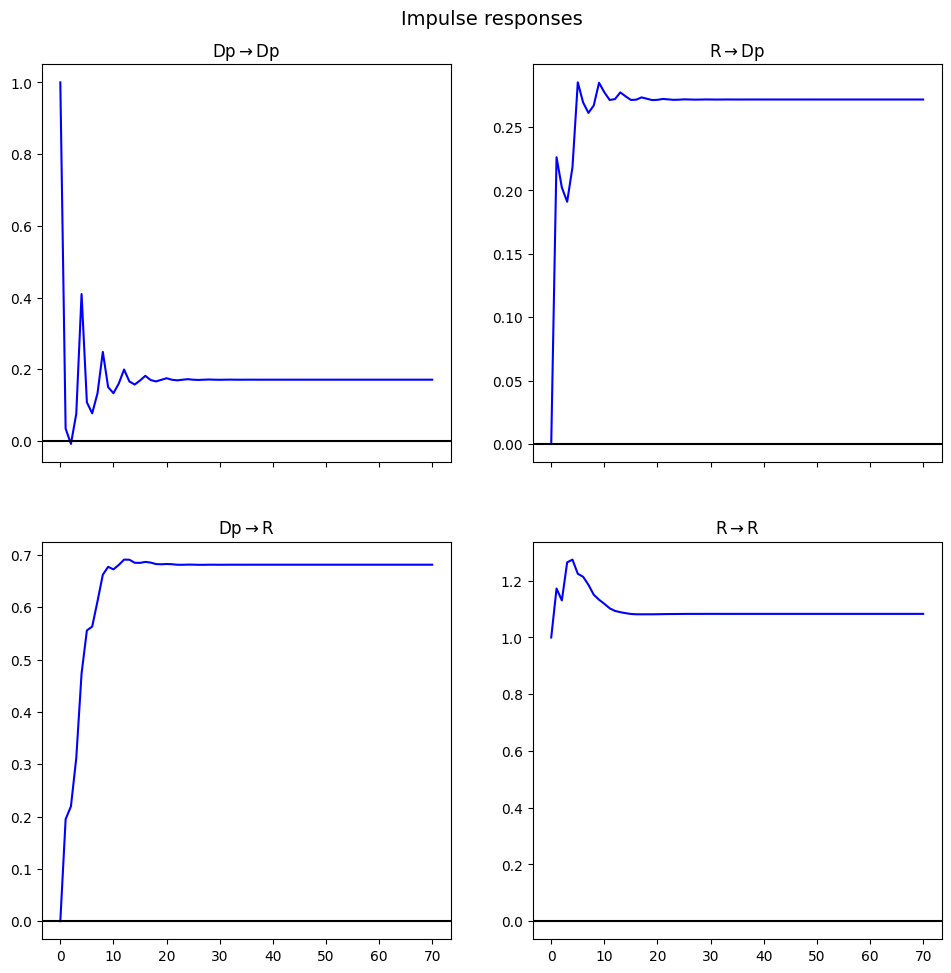

In [32]:
num_periods = 70
ir = vecm_res.irf(periods=num_periods)
ir.plot(plot_stderr=False)
plt.show()

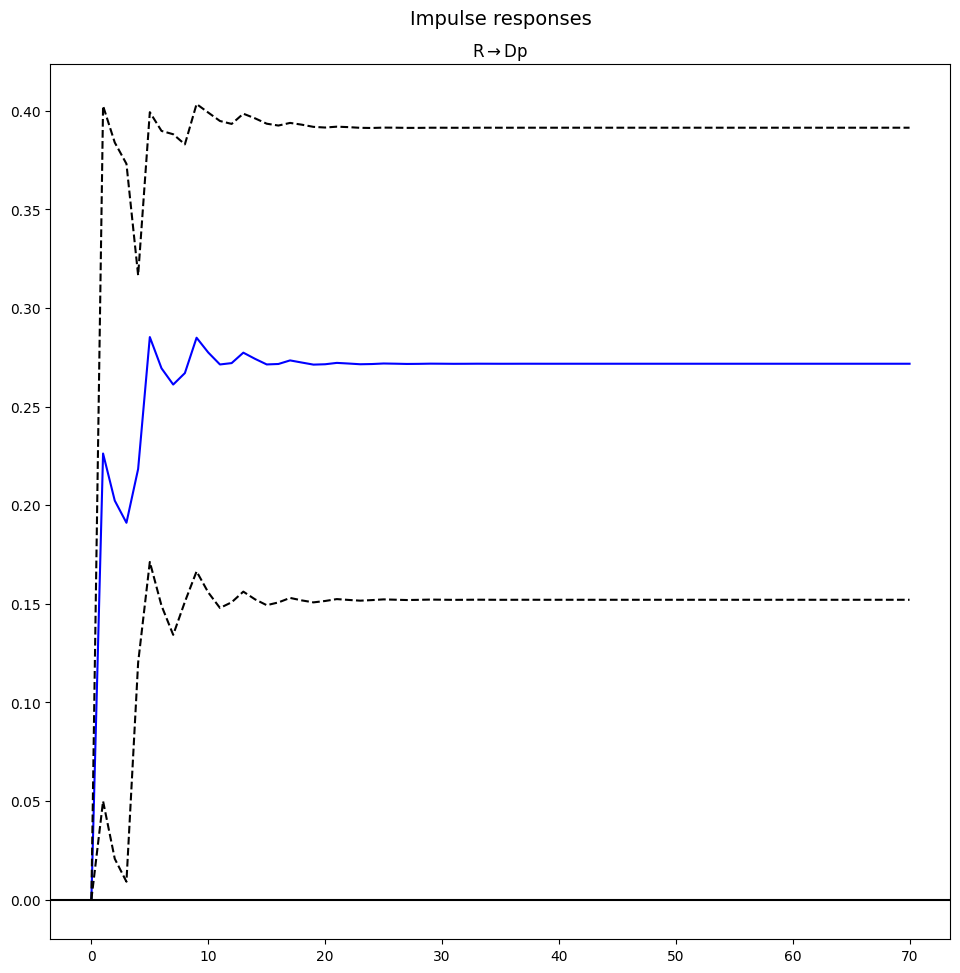

In [33]:
ir.plot(impulse = 'R', response='Dp')
plt.show()

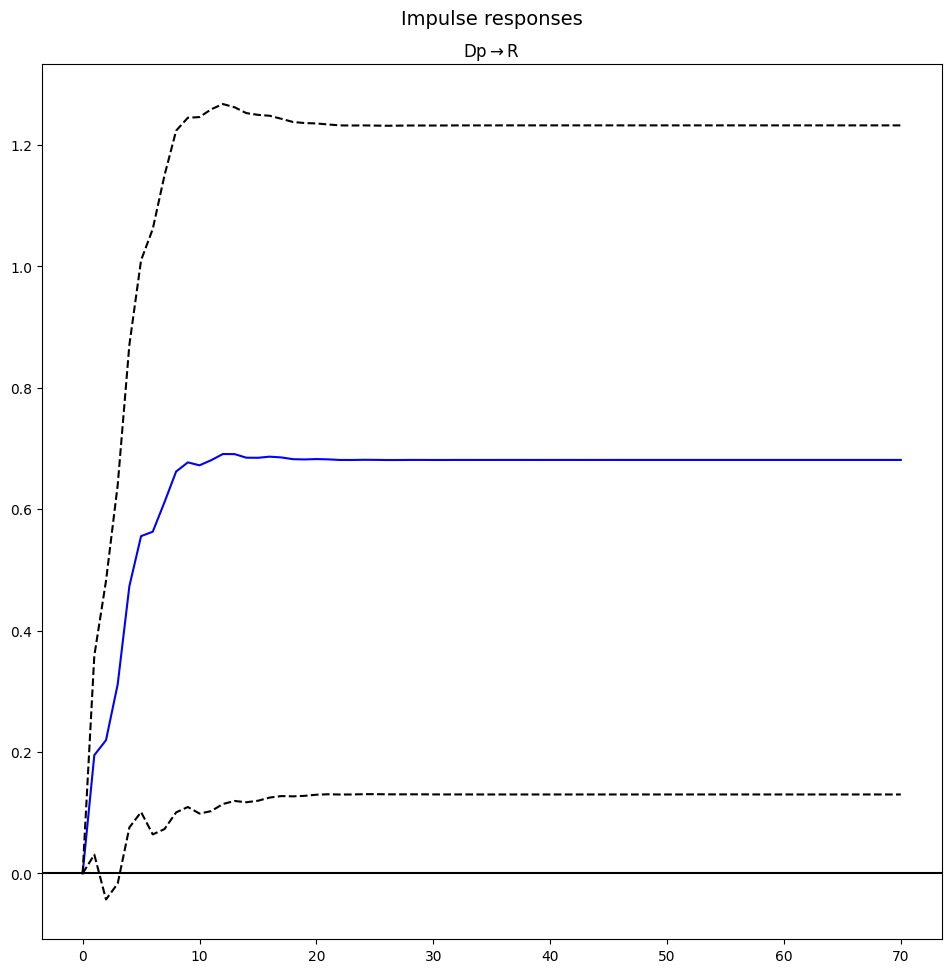

In [34]:
ir.plot(impulse = 'Dp', response='R')
plt.show()

Diagnostics

Testing for nonnormality and for residual autocorrelation is possible with the test_normality() and test_whiteness() methods which return a NormalityTestResults and a WhitenessTestResults object respectively. Both mentioned classes are subclasses of HypothesisTestResults - just as in the case of the causality tests. So we again have the same possibilities as above for inspecting those objects.

In [35]:
#testing for Non-normality

In [36]:
norm_test = vecm_res.test_normality()
norm_test.summary()

Test statistic,Critical value,p-value,df
2.118,9.488,0.714,4


In [37]:
# Checking for residual autocorrelation

In [38]:
white_test = vecm_res.test_whiteness(nlags=12, adjusted=True)
white_test.summary()

Test statistic,Critical value,p-value,df
33.52,48.60,0.491,34


FEVD

In [39]:
# 파이썬 VECM 라이브러리는 FEVD function 따로 없는듯
# 대신 alpha (외생적 충격이 발생했을 때 균형으로 회귀하는 속도를 나타내는 계수) 사용하면 될 듯